In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from preprocessing import *
from split_data import *
from training_models import *
from load_models import *
import random
from load_data import *
from metric import metrics_for_binary_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [3]:
path = '/mnt/n193/physionet_data/Physionet2022_PCG/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/' # this path is dataset path of PhysioNet 2022

wave_info, demo_info, outcomes, grade, paitnet_id = get_dataset(path)

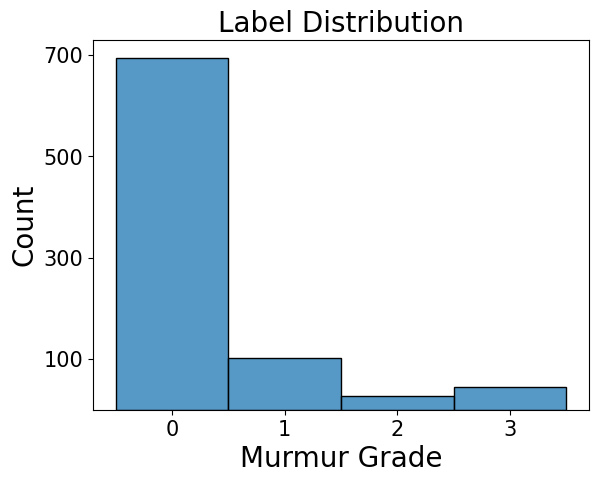

In [4]:
sns.histplot(np.sort(grade).astype(str))
plt.xticks([0,1,2,3], fontsize = 15)
plt.yticks([100, 300, 500, 700], fontsize = 15)
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Murmur Grade', fontsize = 20)
plt.title('Label Distribution', fontsize = 20)
plt.show()

([], [])

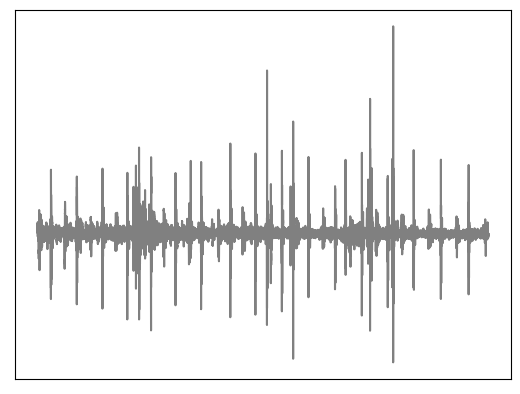

In [5]:
plt.plot(wave_info[0][0][0], color = 'grey')
plt.xticks([])
plt.yticks([])

# Step 2. Split Data

In [6]:
train_x, test_x, train_outcome, test_outcome, train_demo, test_demo, train_grade, test_grade, fold, mur_list, train_sub_id, test_sub_id = get_split_for_murmurnet(
                                            wave_info, demo_info, outcomes, grade, test_size = 0.2, id_set = paitnet_id) # Data split by patient id
print(len(train_x), len(test_x))
# mur_list = neg_idx, pos_idx, strong_idx, weak_idx, inno_idx

484 122


# Step 3. Training

In [7]:
from sklearn.model_selection import train_test_split

ensemble1, ensemble2 = train_test_split(mur_list[1], test_size = len(mur_list[2]), random_state = 42)

In [8]:
# Define sample of TCN and delete in each fold
from sklearn.model_selection import train_test_split
ensemble1, ensemble2 = train_test_split(mur_list[1], test_size = len(mur_list[2]), random_state = 42)

murmurnet_domain1 = np.concatenate(  [mur_list[0], mur_list[1]] ) # total domain (normal vs pathological murmur)
murmurnet_domain2 = np.concatenate(  [mur_list[0], mur_list[2]] ) # strong murmur domain
murmurnet_domain3 = np.concatenate(  [mur_list[0], mur_list[3]] ) # weak murmur domain
murmurnet_domain4 = np.concatenate(  [mur_list[0], ensemble1] ) # random ensemble1 domain (sample size was same to weak domain)
murmurnet_domain5 = np.concatenate(  [mur_list[0], ensemble2] ) # random ensemble2 domain (sample size was same to strong domain)

# Training domain
murmurnet_domain = murmurnet_domain1.copy() # Data domain selection

for i in range(0, 5):
    temp_fold = fold[i]
    del_idx = []
    for j in range(0, len(temp_fold)):
        if temp_fold[j] not in murmurnet_domain:
            del_idx.append(j)
    fold[i] = np.delete(temp_fold, del_idx)

In [9]:
train = [[0,1,2], [1,2,3], [2,3,4], [3,4,0], [4,0,1]]
valid1 = [3,4,0,1,2]
valid2 = [4,0,1,2,3]
sampling_rate = 2000

951 324 310
(21907, 1, 2000) (7870, 1, 2000) (7109, 2000, 1)
(21907,) (7870,) (7109,)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 997]             224
            Conv1d-2             [-1, 128, 997]           4,096
            Conv1d-3             [-1, 128, 999]          49,280
            Conv1d-4             [-1, 128, 999]          49,280
           Chomp1d-5             [-1, 128, 997]               0
           Chomp1d-6             [-1, 128, 997]               0
               ELU-7             [-1, 128, 997]               0
               ELU-8             [-1, 128, 997]               0
            Conv1d-9             [-1, 128, 999]          49,280
           Conv1d-10             [-1, 128, 999]          49,280
          Chomp1d-11             [-1, 128, 997]               0
          Chomp1d-12             [-1, 128, 997]               0
              ELU

100%|██████████| 171/171 [00:19<00:00,  8.82it/s]


Epoch:  1
Loss:  0.4252902451488707
AUROC:  0.7361297579387485


100%|██████████| 61/61 [00:02<00:00, 28.86it/s]


model_saved!
Epoch:  1
Val_Loss:  0.44370554705135157
Val_AUROC:  0.8520604048512781


100%|██████████| 171/171 [00:19<00:00,  8.91it/s]


Epoch:  2
Loss:  0.25999551105220414
AUROC:  0.9219854955160861


100%|██████████| 61/61 [00:02<00:00, 27.43it/s]


model_saved!
Epoch:  2
Val_Loss:  0.38417241172712363
Val_AUROC:  0.8677338370169335


100%|██████████| 171/171 [00:19<00:00,  8.91it/s]


Epoch:  3
Loss:  0.20441893135246472
AUROC:  0.954775121506754


100%|██████████| 61/61 [00:02<00:00, 26.93it/s]


model_saved!
Epoch:  3
Val_Loss:  0.3941019030868031
Val_AUROC:  0.880233814968354


100%|██████████| 171/171 [00:19<00:00,  8.82it/s]


Epoch:  4
Loss:  0.16706768981023135
AUROC:  0.971746602892232


100%|██████████| 61/61 [00:02<00:00, 27.55it/s]


model_saved!
Epoch:  4
Val_Loss:  0.42004162146419777
Val_AUROC:  0.8926450456515919


100%|██████████| 171/171 [00:19<00:00,  8.84it/s]


Epoch:  5
Loss:  0.14802998228118433
AUROC:  0.979151544141443


100%|██████████| 61/61 [00:02<00:00, 26.97it/s]


model_saved!
Epoch:  5
Val_Loss:  0.35304826937738004
Val_AUROC:  0.8950431469184732


100%|██████████| 171/171 [00:19<00:00,  8.80it/s]


Epoch:  6
Loss:  0.11611634516838003
AUROC:  0.9878275514322017


100%|██████████| 61/61 [00:02<00:00, 26.80it/s]


Epoch:  6
Val_Loss:  0.5230387564076752
Val_AUROC:  0.8806177278154997


100%|██████████| 171/171 [00:19<00:00,  8.66it/s]


Epoch:  7
Loss:  0.09844827278359236
AUROC:  0.9916237453625686


100%|██████████| 61/61 [00:02<00:00, 28.93it/s]


Epoch:  7
Val_Loss:  0.5025025586612888
Val_AUROC:  0.8899899182181961


100%|██████████| 171/171 [00:19<00:00,  8.76it/s]


Epoch:  8
Loss:  0.07766976619237348
AUROC:  0.9951589108398942


100%|██████████| 61/61 [00:02<00:00, 27.89it/s]


model_saved!
Epoch:  8
Val_Loss:  0.4288623855739344
Val_AUROC:  0.8988818195259359


100%|██████████| 171/171 [00:19<00:00,  8.66it/s]


Epoch:  9
Loss:  0.06509445058672052
AUROC:  0.9970287077548806


100%|██████████| 61/61 [00:02<00:00, 25.52it/s]


Epoch:  9
Val_Loss:  0.6377975549854218
Val_AUROC:  0.898201993869433


100%|██████████| 171/171 [00:19<00:00,  8.65it/s]


Epoch:  10
Loss:  0.04684460298185461
AUROC:  0.9983897600421106


100%|██████████| 61/61 [00:02<00:00, 26.38it/s]


Epoch:  10
Val_Loss:  0.46981844330420247
Val_AUROC:  0.8786306933064479
Finished Training
959 310 316
(22375, 1, 2000) (7109, 1, 2000) (7402, 2000, 1)
(22375,) (7109,) (7402,)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 997]             224
            Conv1d-2             [-1, 128, 997]           4,096
            Conv1d-3             [-1, 128, 999]          49,280
            Conv1d-4             [-1, 128, 999]          49,280
           Chomp1d-5             [-1, 128, 997]               0
           Chomp1d-6             [-1, 128, 997]               0
               ELU-7             [-1, 128, 997]               0
               ELU-8             [-1, 128, 997]               0
            Conv1d-9             [-1, 128, 999]          49,280
           Conv1d-10             [-1, 128, 999]          49,280
          Chomp1d-11             [-1, 128, 997]       

100%|██████████| 174/174 [00:19<00:00,  8.72it/s]


Epoch:  1
Loss:  0.4609219692219263
AUROC:  0.7330683659172914


100%|██████████| 55/55 [00:02<00:00, 27.37it/s]


model_saved!
Epoch:  1
Val_Loss:  0.29820819795131687
Val_AUROC:  0.9014339993914811


100%|██████████| 174/174 [00:19<00:00,  8.86it/s]


Epoch:  2
Loss:  0.29442145135895975
AUROC:  0.9118315416732671


100%|██████████| 55/55 [00:02<00:00, 27.05it/s]


model_saved!
Epoch:  2
Val_Loss:  0.2549424534494227
Val_AUROC:  0.9247428862865293


100%|██████████| 174/174 [00:19<00:00,  8.86it/s]


Epoch:  3
Loss:  0.23423302062283974
AUROC:  0.9477964558591884


100%|██████████| 55/55 [00:01<00:00, 29.32it/s]


Epoch:  3
Val_Loss:  0.2598895197564905
Val_AUROC:  0.9214966358431226


100%|██████████| 174/174 [00:19<00:00,  8.91it/s]


Epoch:  4
Loss:  0.19044179233840144
AUROC:  0.9660913383594221


100%|██████████| 55/55 [00:01<00:00, 27.68it/s]


Epoch:  4
Val_Loss:  0.31625171330842106
Val_AUROC:  0.8997459508353682


100%|██████████| 174/174 [00:20<00:00,  8.69it/s]


Epoch:  5
Loss:  0.15387684873294552
AUROC:  0.9787823994799646


100%|██████████| 55/55 [00:01<00:00, 28.70it/s]


Finished Training
946 316 323
(22416, 1, 2000) (7402, 1, 2000) (7068, 2000, 1)
(22416,) (7402,) (7068,)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 997]             224
            Conv1d-2             [-1, 128, 997]           4,096
            Conv1d-3             [-1, 128, 999]          49,280
            Conv1d-4             [-1, 128, 999]          49,280
           Chomp1d-5             [-1, 128, 997]               0
           Chomp1d-6             [-1, 128, 997]               0
               ELU-7             [-1, 128, 997]               0
               ELU-8             [-1, 128, 997]               0
            Conv1d-9             [-1, 128, 999]          49,280
           Conv1d-10             [-1, 128, 999]          49,280
          Chomp1d-11             [-1, 128, 997]               0
          Chomp1d-12             [-1, 128, 997]               0

100%|██████████| 175/175 [00:20<00:00,  8.56it/s]


Epoch:  1
Loss:  0.4522420289686751
AUROC:  0.7587871708531527


100%|██████████| 57/57 [00:02<00:00, 26.90it/s]


model_saved!
Epoch:  1
Val_Loss:  0.3337763872062951
Val_AUROC:  0.9292935497544471


100%|██████████| 175/175 [00:20<00:00,  8.56it/s]


Epoch:  2
Loss:  0.29977127288069055
AUROC:  0.9086668076853852


100%|██████████| 57/57 [00:02<00:00, 25.62it/s]


model_saved!
Epoch:  2
Val_Loss:  0.2114615952759458
Val_AUROC:  0.943893495940916


100%|██████████| 175/175 [00:20<00:00,  8.53it/s]


Epoch:  3
Loss:  0.24912648209503716
AUROC:  0.9365748701468521


100%|██████████| 57/57 [00:02<00:00, 24.46it/s]


model_saved!
Epoch:  3
Val_Loss:  0.23009579877058664
Val_AUROC:  0.9473425111788799


100%|██████████| 175/175 [00:20<00:00,  8.54it/s]


Epoch:  4
Loss:  0.2162343556114606
AUROC:  0.9567780481101602


100%|██████████| 57/57 [00:02<00:00, 27.49it/s]


model_saved!
Epoch:  4
Val_Loss:  0.20530213167270017
Val_AUROC:  0.9509465324289603


100%|██████████| 175/175 [00:20<00:00,  8.57it/s]


Epoch:  5
Loss:  0.1741907844798905
AUROC:  0.9738137762137216


100%|██████████| 57/57 [00:02<00:00, 26.44it/s]


Epoch:  5
Val_Loss:  0.21784492961147367
Val_AUROC:  0.9422418978189678


100%|██████████| 175/175 [00:20<00:00,  8.67it/s]


Epoch:  6
Loss:  0.14210976072720122
AUROC:  0.9839712862502585


100%|██████████| 57/57 [00:02<00:00, 27.03it/s]


Epoch:  6
Val_Loss:  0.2399721242356719
Val_AUROC:  0.9318659746552694


100%|██████████| 175/175 [00:20<00:00,  8.71it/s]


Epoch:  7
Loss:  0.11965307406016762
AUROC:  0.9898303471486687


100%|██████████| 57/57 [00:02<00:00, 27.21it/s]


Finished Training
950 323 312
(22381, 1, 2000) (7068, 1, 2000) (7437, 2000, 1)
(22381,) (7068,) (7437,)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 997]             224
            Conv1d-2             [-1, 128, 997]           4,096
            Conv1d-3             [-1, 128, 999]          49,280
            Conv1d-4             [-1, 128, 999]          49,280
           Chomp1d-5             [-1, 128, 997]               0
           Chomp1d-6             [-1, 128, 997]               0
               ELU-7             [-1, 128, 997]               0
               ELU-8             [-1, 128, 997]               0
            Conv1d-9             [-1, 128, 999]          49,280
           Conv1d-10             [-1, 128, 999]          49,280
          Chomp1d-11             [-1, 128, 997]               0
          Chomp1d-12             [-1, 128, 997]               0

100%|██████████| 174/174 [00:19<00:00,  8.72it/s]


Epoch:  1
Loss:  0.4788247499315219
AUROC:  0.7304659911176707


100%|██████████| 55/55 [00:01<00:00, 28.18it/s]


model_saved!
Epoch:  1
Val_Loss:  0.32926426882093607
Val_AUROC:  0.8259080985784683


100%|██████████| 174/174 [00:19<00:00,  8.72it/s]


Epoch:  2
Loss:  0.29825558162283633
AUROC:  0.9004872140816759


100%|██████████| 55/55 [00:01<00:00, 29.08it/s]


model_saved!
Epoch:  2
Val_Loss:  0.27806386405771427
Val_AUROC:  0.8854566651001408


100%|██████████| 174/174 [00:19<00:00,  8.81it/s]


Epoch:  3
Loss:  0.2475704038622737
AUROC:  0.9322749193144947


100%|██████████| 55/55 [00:01<00:00, 27.73it/s]


model_saved!
Epoch:  3
Val_Loss:  0.2405487927523527
Val_AUROC:  0.9342808389722307


100%|██████████| 174/174 [00:19<00:00,  8.81it/s]


Epoch:  4
Loss:  0.21611584997040106
AUROC:  0.9517208000157581


100%|██████████| 55/55 [00:01<00:00, 28.52it/s]


model_saved!
Epoch:  4
Val_Loss:  0.20350868132981395
Val_AUROC:  0.9498942941119733


100%|██████████| 174/174 [00:19<00:00,  8.80it/s]


Epoch:  5
Loss:  0.19053965928996436
AUROC:  0.9658472159998981


100%|██████████| 55/55 [00:02<00:00, 25.12it/s]


Epoch:  5
Val_Loss:  0.21830215819857338
Val_AUROC:  0.941755325895819


100%|██████████| 174/174 [00:19<00:00,  8.75it/s]


Epoch:  6
Loss:  0.161712410977517
AUROC:  0.9776303213568911


100%|██████████| 55/55 [00:01<00:00, 28.03it/s]


Epoch:  6
Val_Loss:  0.24405953071334135
Val_AUROC:  0.9380779996906042


100%|██████████| 174/174 [00:19<00:00,  8.81it/s]


Epoch:  7
Loss:  0.13857231730188455
AUROC:  0.985451529293071


100%|██████████| 55/55 [00:01<00:00, 28.64it/s]


Finished Training
949 312 324
(21579, 1, 2000) (7437, 1, 2000) (7870, 2000, 1)
(21579,) (7437,) (7870,)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 997]             224
            Conv1d-2             [-1, 128, 997]           4,096
            Conv1d-3             [-1, 128, 999]          49,280
            Conv1d-4             [-1, 128, 999]          49,280
           Chomp1d-5             [-1, 128, 997]               0
           Chomp1d-6             [-1, 128, 997]               0
               ELU-7             [-1, 128, 997]               0
               ELU-8             [-1, 128, 997]               0
            Conv1d-9             [-1, 128, 999]          49,280
           Conv1d-10             [-1, 128, 999]          49,280
          Chomp1d-11             [-1, 128, 997]               0
          Chomp1d-12             [-1, 128, 997]               0

100%|██████████| 168/168 [00:19<00:00,  8.79it/s]


Epoch:  1
Loss:  0.4822378076967737
AUROC:  0.6768067536853335


100%|██████████| 58/58 [00:02<00:00, 26.77it/s]


model_saved!
Epoch:  1
Val_Loss:  0.37229684406313396
Val_AUROC:  0.8303095367436693


100%|██████████| 168/168 [00:19<00:00,  8.78it/s]


Epoch:  2
Loss:  0.28025747099447806
AUROC:  0.9082907248392893


100%|██████████| 58/58 [00:02<00:00, 27.71it/s]


model_saved!
Epoch:  2
Val_Loss:  0.28829535148267094
Val_AUROC:  0.9037734452647458


100%|██████████| 168/168 [00:19<00:00,  8.43it/s]


Epoch:  3
Loss:  0.22629846681264193
AUROC:  0.9432353667658868


100%|██████████| 58/58 [00:02<00:00, 24.83it/s]


model_saved!
Epoch:  3
Val_Loss:  0.3285415177715236
Val_AUROC:  0.9094164121308302


100%|██████████| 168/168 [00:19<00:00,  8.44it/s]


Epoch:  4
Loss:  0.1820043116098359
AUROC:  0.9622981394972097


100%|██████████| 58/58 [00:02<00:00, 24.98it/s]


model_saved!
Epoch:  4
Val_Loss:  0.3607625280474793
Val_AUROC:  0.9232520955157023


100%|██████████| 168/168 [00:19<00:00,  8.44it/s]


Epoch:  5
Loss:  0.15984409448823753
AUROC:  0.9745573688800463


100%|██████████| 58/58 [00:02<00:00, 25.29it/s]


Epoch:  5
Val_Loss:  0.45279849166500147
Val_AUROC:  0.9193706577974743


100%|██████████| 168/168 [00:19<00:00,  8.52it/s]


Epoch:  6
Loss:  0.13533927012412325
AUROC:  0.981753177708584


100%|██████████| 58/58 [00:02<00:00, 27.14it/s]


Epoch:  6
Val_Loss:  0.31718408085148914
Val_AUROC:  0.9222810316974334


100%|██████████| 168/168 [00:19<00:00,  8.68it/s]


Epoch:  7
Loss:  0.10980736752528517
AUROC:  0.9875741297146503


100%|██████████| 58/58 [00:02<00:00, 26.47it/s]


Finished Training


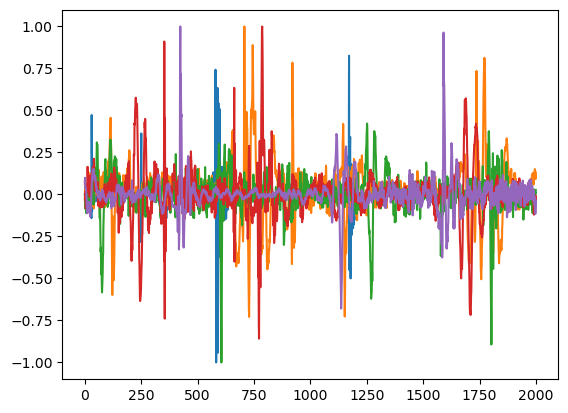

In [10]:
for n_fold in range(0, 5):
    train_fold = train[n_fold] 
    train_fold1 = train_fold[0]
    train_fold2 = train_fold[1]
    train_fold3 = train_fold[2]
    
    valid1_fold = valid1[n_fold]
    valid2_fold = valid2[n_fold]
    
    train_idx = np.concatenate((fold[train_fold1], fold[train_fold2], fold[train_fold3]))
    valid1_idx = fold[valid1_fold]
    valid2_idx = fold[valid2_fold]
    
    train_wav, train_wav_label = generate_pair(train_idx, train_x)
    valid1_wav, valid1_wav_label = generate_pair(valid1_idx, train_x)
    valid2_wav, valid2_wav_label = generate_pair(valid2_idx, train_x)
    print(len(train_wav), len(valid1_wav), len(valid2_wav))
    
    train_features, train_target = segmentation(train_wav, train_wav_label, sampling_rate = sampling_rate, seconds = 1)
    valid1_features, valid1_target = segmentation(valid1_wav, valid1_wav_label, sampling_rate = sampling_rate, seconds = 1)
    valid2_features, valid2_target = segmentation(valid2_wav, valid2_wav_label, sampling_rate = sampling_rate, seconds = 1)
    
    # reshape for Pytorch
    train_features = train_features.reshape((train_features.shape[0], train_features.shape[2], train_features.shape[1]))
    valid1_features = valid1_features.reshape((valid1_features.shape[0], valid1_features.shape[2], valid1_features.shape[1]))
    print(train_features.shape, valid1_features.shape, valid2_features.shape)
    print(train_target.shape, valid1_target.shape, valid2_target.shape)
    
    arr = np.arange(len(train_features))
    np.random.seed(42)
    np.random.shuffle(arr)
    train_features = train_features[arr]
    train_target = train_target[arr]
    plt.plot(train_features[0].flatten())
    
    train_collection = []
    valid_collection = []
    for i in range(0, len(train_features)):
        train_collection.append([train_features[i], np.array([train_target[i]])])
    for i in range(0, len(valid1_features)):
        valid_collection.append([valid1_features[i], np.array([valid1_target[i]])])
    
    # Training
    model_name = 'TCN_fold{}_' # Saved model name
    model = model_name.format(n_fold+1)
    save_path = 'save_model/' # model saved folder
    train_loss, train_metric, valid_loss, valid_metric = training_models(train_collection, valid_collection, save_path = save_path + model,
                                                                         gpu_num = 1, random_seed = 42, num_epochs = 10, batch_size = 128, learning_rate = 0.001, patience = 3, n_ch = 1,
                                                                         model_name = 'tcn' # training various model. please select model option of [vgg16, resnet, inception, tcn, ctan, convnext]
                                                                        ) # if train weak model, set batch_size = 128 because of error "Only one class present in y_true"
    df = pd.DataFrame({'train_loss':train_loss, 'train_metric':train_metric, 'valid_loss':valid_loss, 'valid_metric':valid_metric})
    df.to_csv(save_path + model + 'model_loss.csv')

# Step4. Feature extraction

In [11]:
from load_data import *
path = '/mnt/n193/physionet_data/Physionet2022_PCG/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/' # this path is dataset path of PhysioNet 2022
wave_info, demo_info, outcomes, grade, paitnet_id = get_dataset(path)
train_x, test_x, train_outcome, test_outcome, train_demo, test_demo, train_grade, test_grade, fold, mur_list, train_id, test_id = get_split_for_murmurnet(
                                            wave_info, demo_info, outcomes, grade, paitnet_id, test_size = 0.2)

In [12]:
model_path = 'save_model/' # write your path of saved model

In [13]:
train_murmur_loc = []
for i in range(0, len(train_x)):
    current_patient = train_x[i]
    current_murmur = ''
    for j in range(0, len(current_patient)):
        current_loc = current_patient[j]
        if current_loc[-1] == 'Present':
            current_murmur = current_murmur + current_loc[-2] + '+'
    train_murmur_loc.append(current_murmur)

test_murmur_loc = []
for i in range(0, len(test_x)):
    current_patient = test_x[i]
    current_murmur = ''
    for j in range(0, len(current_patient)):
        current_loc = current_patient[j]
        if current_loc[-1] == 'Present':
            current_murmur = current_murmur + current_loc[-2] + '+'
    test_murmur_loc.append(current_murmur)

In [14]:
train = [[0,1,2], [1,2,3], [2,3,4], [3,4,0], [4,0,1]]
valid1 = [3,4,0,1,2]
valid2 = [4,0,1,2,3]

os.environ["CUDA_VISIBLE_DEVICES"] = str(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_df_cv = []
valid_df_cv = []
test_df_cv = []
for n_fold in range(0, 5):
    train_fold = train[n_fold]
    train_fold1 = train_fold[0]
    train_fold2 = train_fold[1]
    train_fold3 = train_fold[2]
    
    valid1_fold = valid1[n_fold]
    valid2_fold = valid2[n_fold]
    
    train_idx = np.concatenate((fold[train_fold1], fold[train_fold2], fold[train_fold3], fold[valid1_fold]))
    valid_idx = fold[valid2_fold]
    
    """Load model"""
    path = 'save_model/TCN_fold{}_model.pt'.format(n_fold + 1)
    param_saved = torch.load(path, map_location = device)
    test_model = load_model(model_name = 'tcn', n_ch = 1).to(device)
    test_model.load_state_dict(param_saved)
    test_model.eval()
    """"""
    
    train_df = pd.DataFrame(np.zeros((len(train_idx), 24)), columns = ['AV_min', 'AV_max', 'AV_median', 'AV_mean',
                                                                       'PV_min', 'PV_max', 'PV_median', 'PV_mean',
                                                                       'TV_min', 'TV_max', 'TV_median', 'TV_mean',
                                                                       'MV_min', 'MV_max', 'MV_median', 'MV_mean',
                                                                       'grade', 'outcome', 'age', 'height', 'weight', 'bmi', 'sex_features', 'is_pregnant']) - 1
    
    valid_df = pd.DataFrame(np.zeros((len(valid_idx), 24)), columns = ['AV_min', 'AV_max', 'AV_median', 'AV_mean',
                                                                       'PV_min', 'PV_max', 'PV_median', 'PV_mean',
                                                                       'TV_min', 'TV_max', 'TV_median', 'TV_mean',
                                                                       'MV_min', 'MV_max', 'MV_median', 'MV_mean',
                                                                       'grade', 'outcome', 'age', 'height', 'weight', 'bmi', 'sex_features', 'is_pregnant']) - 1
    
    test_df = pd.DataFrame(np.zeros((len(test_x), 24)), columns = ['AV_min', 'AV_max', 'AV_median', 'AV_mean',
                                                                   'PV_min', 'PV_max', 'PV_median', 'PV_mean',
                                                                   'TV_min', 'TV_max', 'TV_median', 'TV_mean',
                                                                   'MV_min', 'MV_max', 'MV_median', 'MV_mean',
                                                                   'grade', 'outcome', 'age', 'height', 'weight', 'bmi', 'sex_features', 'is_pregnant']) - 1
    
    train_df['grade'] = train_grade[train_idx]
    valid_df['grade'] = train_grade[valid_idx]
    test_df['grade'] = test_grade
    train_df['outcome'] = train_outcome[train_idx]
    valid_df['outcome'] = train_outcome[valid_idx]
    test_df['outcome'] = test_outcome
    
    train_df['mur_loc'] = [train_murmur_loc[k] for k in train_idx]
    valid_df['mur_loc'] = [train_murmur_loc[k] for k in valid_idx]
    test_df['mur_loc'] = test_murmur_loc
    
    train_df[['age', 'height', 'weight', 'bmi', 'sex_features', 'is_pregnant']] = train_demo[train_idx]
    valid_df[['age', 'height', 'weight', 'bmi', 'sex_features', 'is_pregnant']] = train_demo[valid_idx]
    test_df[['age', 'height', 'weight', 'bmi', 'sex_features', 'is_pregnant']] = test_demo
    
    train_df['patient_id'] = train_id[train_idx]
    valid_df['patient_id'] = train_id[valid_idx]
    test_df['patient_id'] = test_id
    
    for i, idx in enumerate(train_idx):
        current_patient = train_x[idx]
        strong_features = []
        weak_features = []
        for j in range(0, len(current_patient)):
            features = []
            loc_name = current_patient[j][2]
            if loc_name == 'Ph':
                continue
            loc_wave = current_patient[j][0]
            for n in range(0, len(loc_wave) - 4000, 2000):
                features.append(get_wave_features(loc_wave[n: n + 4000], featuresFs = 2000))
            features = np.array(features)
            if len(features) != 0:
                features = features.reshape((len(features), 1, 2000))
                features = torch.Tensor(features)
                features = features.to(device).float()
                pred_strong = test_model(features).cpu().detach().flatten().numpy()
                
                # length.append(len(pred))
                mean_feature_strong = np.mean(pred_strong)
                median_feature_strong = np.median(pred_strong)
                max_feature_strong = np.quantile(pred_strong,  q = 0.95)
                min_feature_strong = np.quantile(pred_strong, q = 0.05)
                
                train_df[loc_name + '_min'][i] = min_feature_strong
                train_df[loc_name + '_max'][i] = max_feature_strong
                train_df[loc_name + '_median'][i] = median_feature_strong
                train_df[loc_name + '_mean'][i] = mean_feature_strong

    for i, idx in enumerate(valid_idx):
        current_patient = train_x[idx]
        strong_features = []
        weak_features = []
        for j in range(0, len(current_patient)):
            features = []
            loc_name = current_patient[j][2]
            if loc_name == 'Ph':
                continue
            loc_wave = current_patient[j][0]
            for n in range(0, len(loc_wave) - 4000, 2000):
                features.append(get_wave_features(loc_wave[n: n + 4000], featuresFs = 2000))
            features = np.array(features)
            if len(features) != 0:
                features = features.reshape((len(features), 1, 2000))
                features = torch.Tensor(features).to(device).float()
                pred_strong = test_model(features).cpu().detach().flatten().numpy()
                
                mean_feature_strong = np.mean(pred_strong)
                median_feature_strong = np.median(pred_strong)
                max_feature_strong = np.quantile(pred_strong,  q = 0.95)
                min_feature_strong = np.quantile(pred_strong, q = 0.05)
                
                valid_df[loc_name + '_min'][i] = min_feature_strong
                valid_df[loc_name + '_max'][i] = max_feature_strong
                valid_df[loc_name + '_median'][i] = median_feature_strong
                valid_df[loc_name + '_mean'][i] = mean_feature_strong
    for i in range(0, len(test_x)):
        current_patient = test_x[i]
        strong_features = []
        weak_features = []
        for j in range(0, len(current_patient)):
            features = []
            loc_name = current_patient[j][2]
            if loc_name == 'Ph':
                continue
            loc_wave = current_patient[j][0]
            for n in range(0, len(loc_wave) - 4000, 2000):
                features.append(get_wave_features(loc_wave[n: n + 4000], featuresFs = 2000))
            features = np.array(features)
            if len(features) != 0:
                features = features.reshape((len(features), 1, 2000))
                features = torch.Tensor(features)
                features = features.to(device).float()
                pred_strong = test_model(features).cpu().detach().flatten().numpy()
                
                # length.append(len(pred))
                mean_feature_strong = np.mean(pred_strong)
                median_feature_strong = np.median(pred_strong)
                max_feature_strong = np.quantile(pred_strong,  q = 0.95)
                min_feature_strong = np.quantile(pred_strong, q = 0.05)
                
                test_df[loc_name + '_min'][i] = min_feature_strong
                test_df[loc_name + '_max'][i] = max_feature_strong
                test_df[loc_name + '_median'][i] = median_feature_strong
                test_df[loc_name + '_mean'][i] = mean_feature_strong
    train_df_cv.append(train_df)
    valid_df_cv.append(valid_df)
    test_df_cv.append(test_df)

In [15]:
save_path = 'save_features/'
save_name = ''
for i in range(0, 5):
    train_df_cv[i].to_csv(save_path + save_name + 'TCN_train_fold'+ str(i+1) + '.csv')
    valid_df_cv[i].to_csv(save_path + save_name + 'TCN_valid_fold'+ str(i+1) + '.csv')
    test_df_cv[i].to_csv(save_path + save_name + 'TCN_test_fold'+ str(i+1) + '.csv')

# Record-level test

In [16]:
feature_path = 'save_features/'
models = 'TCN'

train_list = []
valid_list = []
test_list = []

for i in range(0, 5):
    temp_train = pd.read_csv(feature_path + models + '_train_fold' + str(i+1) + '.csv', index_col = 0)
    temp_valid = pd.read_csv(feature_path + models + '_valid_fold' + str(i+1) + '.csv', index_col = 0)
    temp_test = pd.read_csv(feature_path + models + '_test_fold' + str(i+1) + '.csv', index_col = 0)
    
    temp_train['mur_loc'] = temp_train['mur_loc'].fillna('none')
    temp_valid['mur_loc'] = temp_valid['mur_loc'].fillna('none')
    temp_test['mur_loc'] = temp_test['mur_loc'].fillna('none')
    
    train_list.append(temp_train)
    valid_list.append(temp_valid)
    test_list.append(temp_test)

In [18]:
sens = []
spec = []
auroc = []
auprc = []
bacc = []
thr = []
input_col = 'mean'
for i in range(0, 5):
    pos_wave = []
    neg_wave = []
    pos_y = []
    neg_y = []
    training_patient = pd.concat([train_list[i]], axis = 0).reset_index(drop = True) # 5CV test
    # training_patient = pd.concat([train_list[i], valid_list[i]], axis = 0).reset_index(drop = True) # holdout test
    for j in range(0, len(training_patient)):
        if (training_patient['grade'][j] == 0)&(training_patient['outcome'][j] == 0): # Normal
            neg_wave.append(training_patient['AV_'+input_col][j])
            neg_wave.append(training_patient['PV_'+input_col][j])
            neg_wave.append(training_patient['TV_'+input_col][j])
            neg_wave.append(training_patient['MV_'+input_col][j])
            neg_y.append(0)
            neg_y.append(0)
            neg_y.append(0)
            neg_y.append(0)
        if (training_patient['grade'][j] >= 1)&(training_patient['outcome'][j] == 0): # Innocent murmur
            neg_wave.append(training_patient['AV_'+input_col][j])
            neg_wave.append(training_patient['PV_'+input_col][j])
            neg_wave.append(training_patient['TV_'+input_col][j])
            neg_wave.append(training_patient['MV_'+input_col][j])
            neg_y.append(0)
            neg_y.append(0)
            neg_y.append(0)
            neg_y.append(0)
        if (training_patient['grade'][j] >= 1)&(training_patient['outcome'][j] == 1): # Pathological murmur
            murmur_aus = training_patient['mur_loc'][j].split('+')
            if 'AV' in murmur_aus:
                pos_wave.append(training_patient['AV_'+input_col][j])
                pos_y.append(1)
            if 'AV' not in murmur_aus:
                neg_wave.append(training_patient['AV_'+input_col][j])
                neg_y.append(0)
            if 'PV' in murmur_aus:
                pos_wave.append(training_patient['PV_'+input_col][j])
                pos_y.append(1)
            if 'PV' not in murmur_aus:
                neg_wave.append(training_patient['PV_'+input_col][j])
                neg_y.append(0)
            if 'TV' in murmur_aus:
                pos_wave.append(training_patient['TV_'+input_col][j])
                pos_y.append(1)
            if 'TV' not in murmur_aus:
                neg_wave.append(training_patient['TV_'+input_col][j])
                neg_y.append(0)
            if 'MV' in murmur_aus:
                pos_wave.append(training_patient['MV_'+input_col][j])
                pos_y.append(1)
            if 'MV' not in murmur_aus:
                neg_wave.append(training_patient['MV_'+input_col][j])
                neg_y.append(0)

    train_x = pos_wave + neg_wave
    train_y = pos_y + neg_y
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    idx = np.where(train_x != -1)[0]
    train_x = train_x[idx]
    train_y = train_y[idx]
    #############################################################################
    pos_wave = []
    neg_wave = []
    pos_y = []
    neg_y = []
    training_patient = pd.concat([valid_list[i]], axis = 0).reset_index(drop = True) # 5CV test
    # training_patient = pd.concat([test_list[i]], axis = 0).reset_index(drop = True) # holdout test
    for j in range(0, len(training_patient)): 
        if (training_patient['grade'][j] == 0)&(training_patient['outcome'][j] == 0): # Normal
            neg_wave.append(training_patient['AV_'+input_col][j])
            neg_wave.append(training_patient['PV_'+input_col][j])
            neg_wave.append(training_patient['TV_'+input_col][j])
            neg_wave.append(training_patient['MV_'+input_col][j])
            neg_y.append(0)
            neg_y.append(0)
            neg_y.append(0)
            neg_y.append(0)
        if (training_patient['grade'][j] >= 1)&(training_patient['outcome'][j] == 0): # Innocent murmur
            neg_wave.append(training_patient['AV_'+input_col][j])
            neg_wave.append(training_patient['PV_'+input_col][j])
            neg_wave.append(training_patient['TV_'+input_col][j])
            neg_wave.append(training_patient['MV_'+input_col][j])
            neg_y.append(0)
            neg_y.append(0)
            neg_y.append(0)
            neg_y.append(0)
        if (training_patient['grade'][j] >= 1)&(training_patient['outcome'][j] == 1): # Pathological murmur
            murmur_aus = training_patient['mur_loc'][j].split('+')
            if 'AV' in murmur_aus:
                pos_wave.append(training_patient['AV_'+input_col][j])
                pos_y.append(1)
            if 'AV' not in murmur_aus:
                neg_wave.append(training_patient['AV_'+input_col][j])
                neg_y.append(0)
            if 'PV' in murmur_aus:
                pos_wave.append(training_patient['PV_'+input_col][j])
                pos_y.append(1)
            if 'PV' not in murmur_aus:
                neg_wave.append(training_patient['PV_'+input_col][j])
                neg_y.append(0)
            if 'TV' in murmur_aus:
                pos_wave.append(training_patient['TV_'+input_col][j])
                pos_y.append(1)
            if 'TV' not in murmur_aus:
                neg_wave.append(training_patient['TV_'+input_col][j])
                neg_y.append(0)
            if 'MV' in murmur_aus:
                pos_wave.append(training_patient['MV_'+input_col][j])
                pos_y.append(1)
            if 'MV' not in murmur_aus:
                neg_wave.append(training_patient['MV_'+input_col][j])
                neg_y.append(0)

    valid_x = pos_wave + neg_wave
    valid_y = pos_y + neg_y
    valid_x = np.array(valid_x)
    valid_y = np.array(valid_y)
    idx = np.where(valid_x != -1)[0]
    valid_x = valid_x[idx]
    valid_y = valid_y[idx]
    th = metrics_for_binary_classification(train_y, train_x, pos_label = 1, threshold_option = 'j_index')['Threshold'].round(3)
    sens.append(metrics_for_binary_classification(valid_y, valid_x, pos_label = 1, threshold_option = th)['Sensitivity'].round(3))
    spec.append(metrics_for_binary_classification(valid_y, valid_x, pos_label = 1, threshold_option = th)['Specificity'].round(3))
    bacc.append(metrics_for_binary_classification(valid_y, valid_x, pos_label = 1, threshold_option = th)['BACC'].round(3))
    auroc.append(metrics_for_binary_classification(valid_y, valid_x, pos_label = 1, threshold_option = th)['AUROC'].round(3))
    auprc.append(metrics_for_binary_classification(valid_y, valid_x, pos_label = 1, threshold_option = th)['AUPRC'].round(3))
    thr.append(th)

In [19]:
results = pd.DataFrame(np.zeros((5,5)), columns = ['Sens','Spec','BACC','AUROC','AUPRC'])
results['Sens'] = sens
results['Spec'] = spec
results['BACC'] = bacc
results['AUROC'] = auroc
results['AUPRC'] = auprc
results['THR'] = thr
results.describe().round(3)

,Sens,Spec,BACC,AUROC,AUPRC,THR
count,5.000,5.000,5.000,5.000,5.000,5.000
mean,0.864,0.932,0.898,0.944,0.857,0.262
std,0.029,0.022,0.009,0.019,0.054,0.138
min,0.833,0.914,0.890,0.913,0.788,0.109
25%,0.850,0.918,0.892,0.945,0.833,0.197
50%,0.853,0.926,0.897,0.948,0.842,0.248
75%,0.875,0.934,0.901,0.950,0.901,0.276
max,0.909,0.969,0.912,0.963,0.922,0.481


# Patient-level test

In [21]:
sens = []
spec = []
auroc = []
auprc = []
bacc = []
f1 = []
thr = []
cm = []
input_col = ['AV_mean', 'PV_mean', 'TV_mean', 'MV_mean', 'grade', 'outcome']

for i in range(0,5):
    training_patient = pd.concat([train_list[i]], axis = 0).reset_index(drop = True) # 5CV test
    # training_patient = pd.concat([train_list[i], valid_list[i]], axis = 0).reset_index(drop = True) # holdout test
    training_patient = training_patient[input_col]
    train_x = []
    train_y = []
    for j in range(0, len(training_patient)):
        patient_feature = []
        if training_patient[input_col[0]][j] >= 0:
            patient_feature.append(training_patient[input_col[0]][j])
        if training_patient[input_col[1]][j] >= 0:
            patient_feature.append(training_patient[input_col[1]][j])
        if training_patient[input_col[2]][j] >= 0:
            patient_feature.append(training_patient[input_col[2]][j])
        if training_patient[input_col[3]][j] >= 0:
            patient_feature.append(training_patient[input_col[3]][j])
        train_x.append(np.mean(patient_feature))
        train_y.append(training_patient['outcome'][j])
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    ####################################################################################################################################################
    training_patient = pd.concat([valid_list[i]], axis = 0).reset_index(drop = True) # 5CV test
    # training_patient = pd.concat([test_list[i]], axis = 0).reset_index(drop = True) # holdout test
    training_patient = training_patient[input_col]
    valid_x = []
    valid_y = []
    for j in range(0, len(training_patient)):
        patient_feature = []
        if training_patient[input_col[0]][j] >= 0:
            patient_feature.append(training_patient[input_col[0]][j])
        if training_patient[input_col[1]][j] >= 0:
            patient_feature.append(training_patient[input_col[1]][j])
        if training_patient[input_col[2]][j] >= 0:
            patient_feature.append(training_patient[input_col[2]][j])
        if training_patient[input_col[3]][j] >= 0:
            patient_feature.append(training_patient[input_col[3]][j])
        valid_x.append(np.mean(patient_feature))
        valid_y.append(training_patient['outcome'][j])
    valid_x = np.array(valid_x)
    valid_y = np.array(valid_y)
    
    th = metrics_for_binary_classification(train_y, train_x, pos_label = 1, threshold_option = 'j_index')['Threshold'].round(3)
    thr.append(th)
    sens.append(metrics_for_binary_classification(valid_y, valid_x, pos_label = 1, threshold_option = th)['Sensitivity'].round(3))
    spec.append(metrics_for_binary_classification(valid_y, valid_x, pos_label = 1, threshold_option = th)['Specificity'].round(3))
    auroc.append(metrics_for_binary_classification(valid_y, valid_x, pos_label = 1, threshold_option = th)['AUROC'].round(3))
    auprc.append(metrics_for_binary_classification(valid_y, valid_x, pos_label = 1, threshold_option = th)['AUPRC'].round(3))
    bacc.append(metrics_for_binary_classification(valid_y, valid_x, pos_label = 1, threshold_option = th)['BACC'].round(3))
    cm.append(metrics_for_binary_classification(valid_y, valid_x, pos_label = 1, threshold_option = th)['CM'])

In [22]:
results = pd.DataFrame(np.zeros((5,5)), columns = ['Sens','Spec','BACC','AUROC','AUPRC'])
results['Sens'] = sens
results['Spec'] = spec
results['BACC'] = bacc
results['AUROC'] = auroc
results['AUPRC'] = auprc
results.describe().round(3)

,Sens,Spec,BACC,AUROC,AUPRC
count,5.000,5.000,5.000,5.000,5.000
mean,0.835,0.935,0.885,0.931,0.873
std,0.046,0.024,0.023,0.029,0.063
min,0.783,0.905,0.858,0.894,0.768
25%,0.826,0.920,0.866,0.911,0.872
50%,0.826,0.932,0.892,0.938,0.882
75%,0.833,0.959,0.896,0.947,0.912
max,0.909,0.959,0.915,0.967,0.930


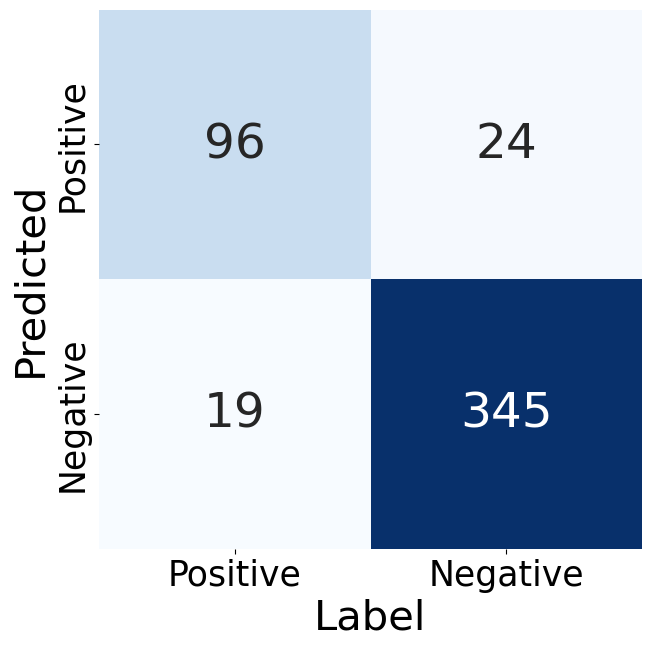

In [24]:
# CM
confusion_maxrix = np.sum(cm,axis = 0) # 5CV test
# confusion_maxrix = cm[1] # holdout test
confusion_maxrix = np.array([[confusion_maxrix[0], confusion_maxrix[2]], [confusion_maxrix[1], confusion_maxrix[3]]])
"""
tp fp
fn tn
"""
plt.figure(figsize = (7,7))
sns.heatmap(confusion_maxrix, annot = True, cmap = 'Blues', cbar = False, fmt = 'd', annot_kws = {"size": 35})
plt.xticks([0.5, 1.5], ['Positive', 'Negative'], fontsize = 25)
plt.yticks([0.5, 1.5], ['Positive', 'Negative'], fontsize = 25)
plt.xlabel('Label', fontsize = 30)
plt.ylabel('Predicted', fontsize = 30)
# plt.savefig('/mnt/n246/project_code/shinjaeman17/PHysioNet2022_paper/Test11_grade_class/code_submission/202402Test/figures/patient_level_transfer_5cv.svg', bbox_inches='tight', pad_inches=0)
plt.show()

# Innocent murmur vs Pathological murmur

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


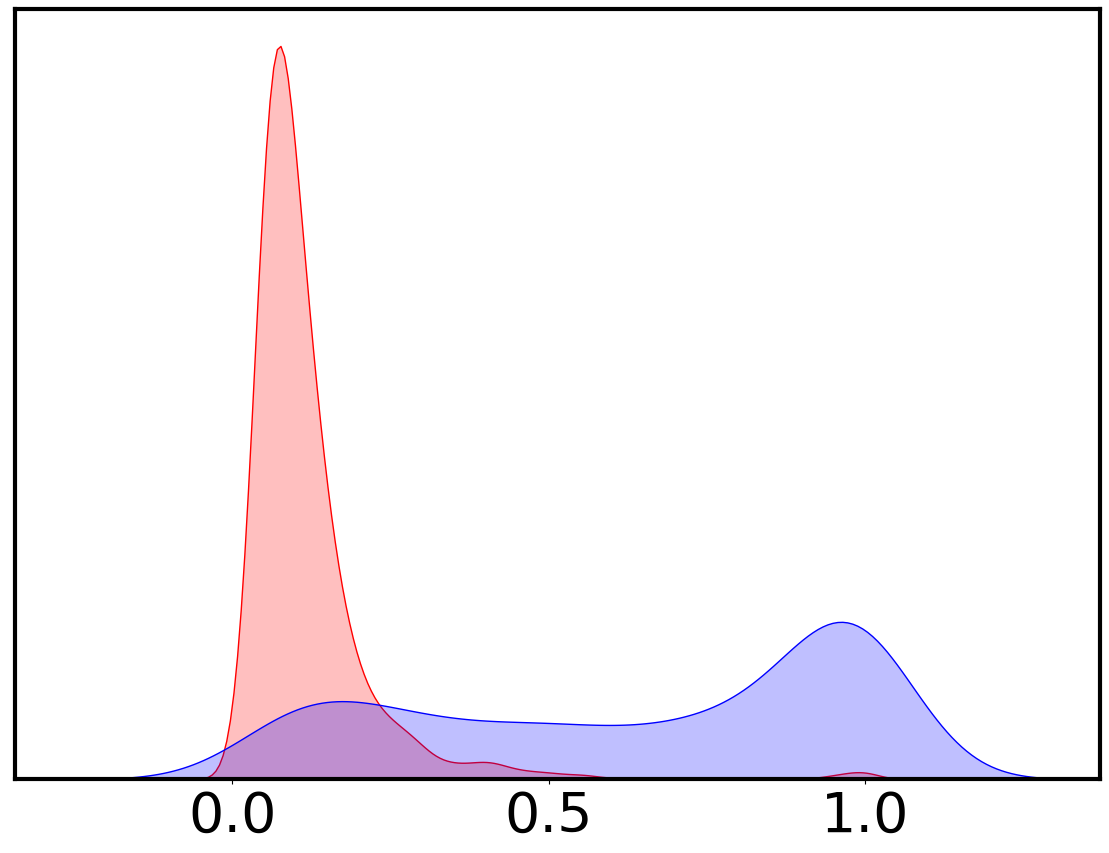

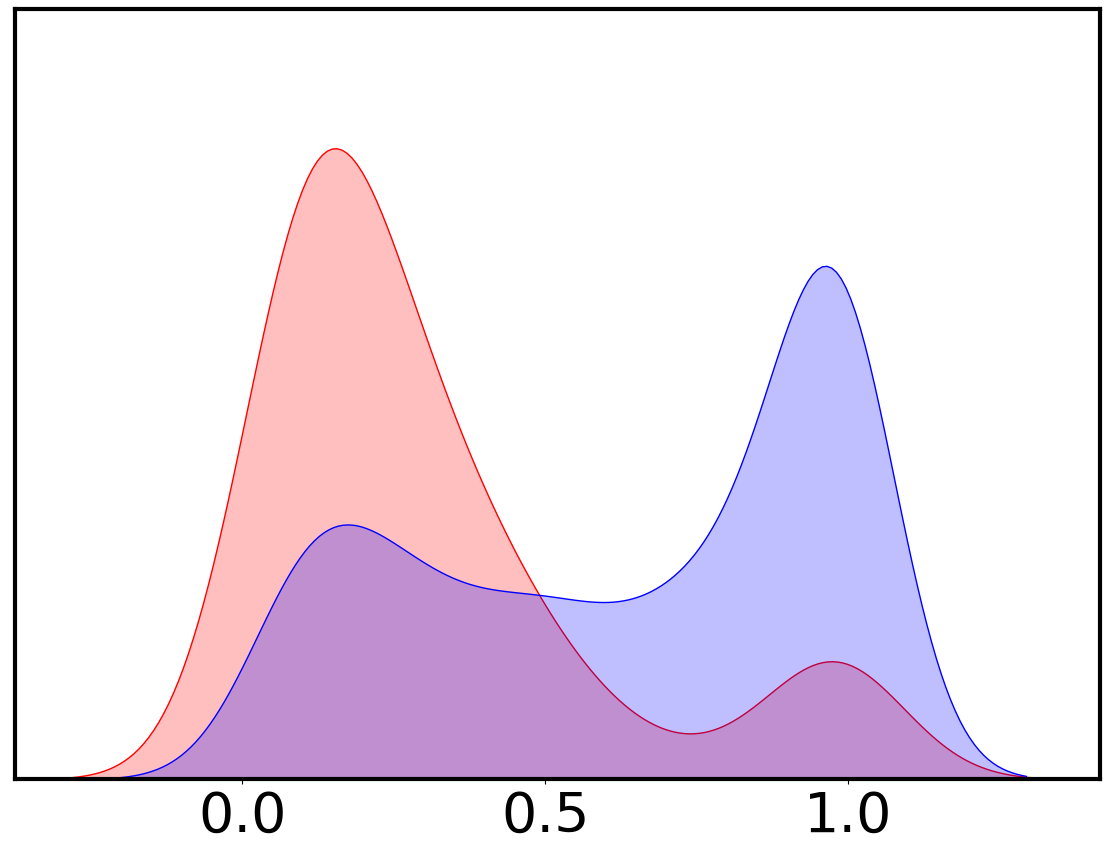

In [27]:
i = 1 # best performance fold in 5CV
plt.rcParams['figure.figsize'] = (14,10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 40

temp = pd.concat([train_list[i], valid_list[i], test_list[i]], axis = 0).reset_index(drop = True)
normal_av = temp[(temp['outcome'] == 0)&(temp['AV_mean'] != -1)]['AV_mean'].values
abnormal_av = temp[(temp['outcome'] == 1)&(temp['AV_mean'] != -1)]['AV_mean'].values

normal_pv = temp[(temp['outcome'] == 0)&(temp['PV_mean'] != -1)]['PV_mean'].values
abnormal_pv = temp[(temp['outcome'] == 1)&(temp['PV_mean'] != -1)]['PV_mean'].values

normal_tv = temp[(temp['outcome'] == 0)&(temp['TV_mean'] != -1)]['TV_mean'].values
abnormal_tv = temp[(temp['outcome'] == 1)&(temp['TV_mean'] != -1)]['TV_mean'].values

normal_mv = temp[(temp['outcome'] == 0)&(temp['MV_mean'] != -1)]['MV_mean'].values
abnormal_mv = temp[(temp['outcome'] == 1)&(temp['MV_mean'] != -1)]['MV_mean'].values

normal = np.concatenate([normal_av, normal_pv, normal_tv, normal_mv])
abnormal = np.concatenate([abnormal_av, abnormal_pv, abnormal_tv, abnormal_mv])

sns.kdeplot(normal, color = 'r', label = 'Normal', fill = True)
sns.kdeplot(abnormal, color = 'b', label = 'Pathological', fill = True)
plt.xticks([0,0.5,1])
plt.yticks([1,3,5])
plt.xlabel('')
plt.ylabel('')
plt.gca().axes.yaxis.set_visible(False)
# plt.legend(loc = 'upper right')
# plt.savefig('figures/normal_vs_pathological.svg', bbox_inches='tight', pad_inches=0)
plt.show()

temp = pd.concat([train_list[i], valid_list[i], test_list[i]], axis = 0).reset_index(drop = True)
innocent_av = temp[(temp['outcome'] == 0)&(temp['AV_mean'] != -1)&(temp['grade'] >= 1)]['AV_mean'].values
pathological_av = temp[(temp['outcome'] == 1)&(temp['AV_mean'] != -1)&(temp['grade'] >=1)]['AV_mean'].values

innocent_pv = temp[(temp['outcome'] == 0)&(temp['PV_mean'] != -1)&(temp['grade'] >= 1)]['PV_mean'].values
pathological_pv = temp[(temp['outcome'] == 1)&(temp['PV_mean'] != -1)&(temp['grade'] >=1)]['PV_mean'].values

innocent_tv = temp[(temp['outcome'] == 0)&(temp['TV_mean'] != -1)&(temp['grade'] >= 1)]['TV_mean'].values
pathological_tv = temp[(temp['outcome'] == 1)&(temp['TV_mean'] != -1)&(temp['grade'] >=1)]['TV_mean'].values

innocent_mv = temp[(temp['outcome'] == 0)&(temp['MV_mean'] != -1)&(temp['grade'] >= 1)]['MV_mean'].values
pathological_mv = temp[(temp['outcome'] == 1)&(temp['MV_mean'] != -1)&(temp['grade'] >=1)]['MV_mean'].values

innocent = np.concatenate([innocent_av, innocent_pv, innocent_tv, innocent_mv])
pathological = np.concatenate([pathological_av, pathological_pv, pathological_tv, pathological_mv])


sns.kdeplot(innocent, color = 'r', label = 'Innocent Murmur', fill = True)
sns.kdeplot(pathological, color = 'b', label = 'Pathological Murmur', fill = True)
plt.xticks([0,0.5,1])
plt.yticks()
plt.xlabel('')
plt.ylabel('')
plt.ylim(0, 2.5)
# plt.legend(loc = 'upper right')
plt.gca().axes.yaxis.set_visible(False)
# plt.savefig('figures/innocent_vs_pathological.svg', bbox_inches='tight', pad_inches=0)
plt.show()